* `torchvision.datasets` - get computer vision datasets
* `torchvision.models` - get pretrained computer vision models
* `torchvision.transforms` - functions for manipulating computer vision data

In [102]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor # convert a PIL Image or array to tensor (HXWXC) to (CXHXW)vfrom (0,255) to (0,1)

import matplotlib.pyplot as plt
import pandas as pd
print(torch.__version__)
print(torchvision.__version__)

2.4.1
0.19.1


# 1. Load data
The dataset we are using is FashionMNIST dataset which provides b/w images of various fashion items. This is used for multiclass classification.

In [3]:
train_data = datasets.FashionMNIST(root="../Dataset/",
                                   train=True,          # if false: will get the testing dataset
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None) # do we need to transform label/target

test_data = datasets.FashionMNIST(root="../Dataset/",
                                   train=False,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None) # do we need to transform label/target

100.0%


Extracting ../Dataset/FashionMNIST\raw\train-images-idx3-ubyte.gz to ../Dataset/FashionMNIST\raw



100.0%


Extracting ../Dataset/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../Dataset/FashionMNIST\raw



100.0%


Extracting ../Dataset/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../Dataset/FashionMNIST\raw



100.0%

Extracting ../Dataset/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../Dataset/FashionMNIST\raw



In [17]:
train_data[0][0] # to get the first training data
train_data[0][1] # to get the first training data label

train_data[0][0].shape # image shape. 1 because it is b/w image

torch.Size([1, 28, 28])

In [15]:
class_names = train_data.classes
class_names, train_data.class_to_idx

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

# 2. Visualise data

The iamge is an Ankle boot.


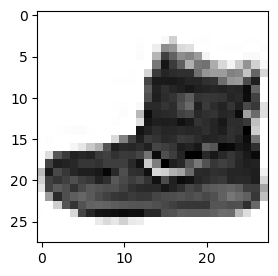

In [28]:
plt.figure(figsize=(5,3))
plt.imshow(train_data[0][0].squeeze(), cmap="Grays")
print(f"The iamge is an {train_data.classes[train_data[0][1]]}.")

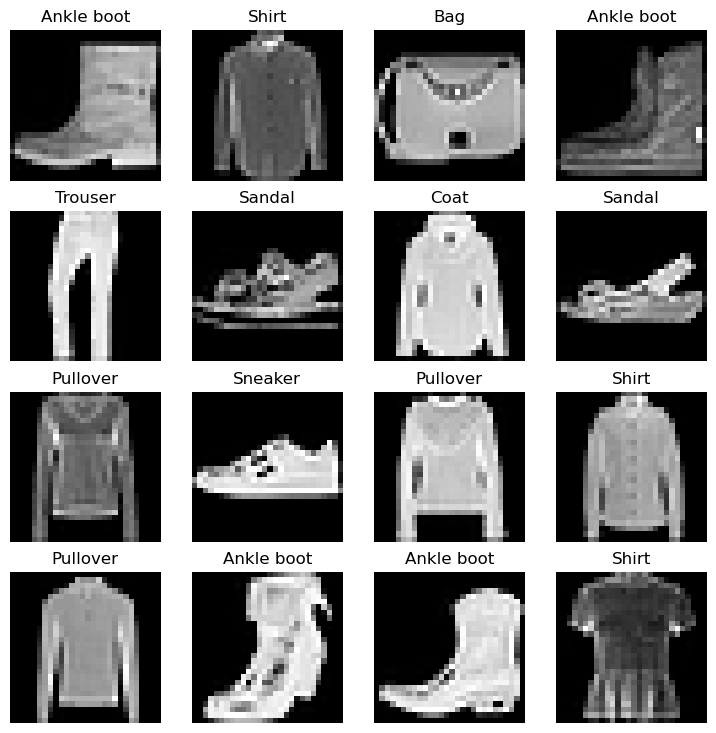

In [57]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1): # to get 16 images
    rdn_idx = torch.randint(0,len(train_data), size=[1]).item()
    img, label = train_data[rdn_idx]

    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis(False)
    plt.title(train_data.classes[label])
plt.show()

# 3. Prepare dataloader
A dataloader converts our dataset into a python iterable, that is it turns our data into batches (or mini-batches). Use of mini-batches is,
* More computationally efficient (to store in memory)
* More updates per epoch

In [60]:
from torch.utils.data import DataLoader

In [63]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True) # req is dataset may be in order therefore not to train each class at a time

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              shuffle=False)

In [69]:
# checks the created dataloader
print(f"Number of batches : {len(train_dataloader)} on training dataset and {len(test_dataloader)} on testing dataset")

Number of batches : 1875 on training dataset and 313 on testing dataset


In [76]:
train_feature_batch, train_lb_batch = next(iter(train_dataloader)) # since iterable, each times gives the next batch values
train_feature_batch.shape, train_lb_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# 4. Build a baseline model
Always its best to start with a baseline model. Therefore, start simply and add complexity.

In [114]:
class FashionMNIST_baseline_model(nn.Module):
    def __init__(self, 
                  inp_features, 
                  hidden_units, 
                  out_classes):
        
        super().__init__()
        self.layer_stack = nn.Sequential(nn.Flatten(),
                                         nn.Linear(in_features=inp_features,
                                                   out_features=hidden_units),
                                         nn.Linear(in_features=hidden_units,
                                                   out_features=out_classes))

    def forward(self, x):
        return self.layer_stack(x)      

In [148]:
torch.manual_seed(42)
model_0 = FashionMNIST_baseline_model(inp_features=784,
                                      hidden_units=10,
                                      out_classes=len(train_data.classes))

# 5. Training
Setup a loss function and optimiser. Since multiclass,
* `nn.CrossEntropyLoss()` - loss function
* `torch.optim.SGD()` - optimiser

In [149]:
loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [150]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # computes element wise equality
    return (correct/len(y_pred))*100

### a. training on cpu

In [151]:
# creating training loop
torch.manual_seed(42)

epochs = 3

for epoch in range(epochs):

    print(f"Epoch: {epoch+1}\n")

    train_loss = 0 # get training loss per epoch

    for batch, (X, y) in enumerate(train_dataloader):

        model_0.train()
        
        # 1. forward pass
        y_pred = model_0(X)

        # 2. calculate loss per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss

        # 3.optimiser zero grad
        optim.zero_grad()

        # 4.loss backward
        loss.backward()

        # 5. step
        optim.step()

        if batch % 400 == 0:
            print(f"looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader) # div by number of batches to get the average loss per epoch

    ### testing ###
    test_loss, test_acc = 0, 0

    model_0.eval()

    with torch.inference_mode():
        for X_test,y_test in test_dataloader:

            # 1. forward pass
            test_pred = model_0(X_test)

            # calculate loss per batch
            test_loss += loss_fn(test_pred, y_test)

            # accuracy
            test_acc += accuracy(y_true=y_test, y_pred=test_pred.argmax(dim=1)) # to get the labels and get the accuracy

        # avg test loss per epoch
        test_loss /= len(test_dataloader)

        # average accuracy per epoch
        test_acc /= len(test_dataloader)

    print(f"Model: {model_0.__class__.__name__} | train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, test accuracy: {test_acc}")

Epoch: 1

looked at 0 / 60000 samples.
looked at 12800 / 60000 samples.
looked at 25600 / 60000 samples.
looked at 38400 / 60000 samples.
looked at 51200 / 60000 samples.
Model: FashionMNIST_baseline_model | train loss: 0.5904 | Test loss: 0.5095, test accuracy: 82.03873801916933
Epoch: 2

looked at 0 / 60000 samples.
looked at 12800 / 60000 samples.
looked at 25600 / 60000 samples.
looked at 38400 / 60000 samples.
looked at 51200 / 60000 samples.
Model: FashionMNIST_baseline_model | train loss: 0.4763 | Test loss: 0.4799, test accuracy: 83.19688498402556
Epoch: 3

looked at 0 / 60000 samples.
looked at 12800 / 60000 samples.
looked at 25600 / 60000 samples.
looked at 38400 / 60000 samples.
looked at 51200 / 60000 samples.
Model: FashionMNIST_baseline_model | train loss: 0.4550 | Test loss: 0.4766, test accuracy: 83.42651757188499


### b. training on gpu with non linearity

In [125]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [167]:
# try with non linearity with gpu
class FashionMNIST_model1(nn.Module):
    def __init__(self, 
                  inp_features, 
                  hidden_units, 
                  out_classes):
        
        super().__init__()
        self.layer_stack = nn.Sequential(nn.Flatten(),
                                         nn.Linear(in_features=inp_features,
                                                   out_features=hidden_units),
                                         nn.ReLU(),
                                         nn.Linear(in_features=hidden_units,
                                                   out_features=out_classes),
                                        nn.ReLU())

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [277]:
# initialise the model
torch.manual_seed(42)
model_1 = FashionMNIST_model1(inp_features=784,
                                      hidden_units=10,
                                      out_classes=len(train_data.classes)).to(device)

In [278]:
loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [279]:
# functionising training and testing loops

def train_step(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn : torch.nn.Module,
             optimizer : torch.optim.Optimizer,
             accuracy_fn,
             device : torch.device = device):

    train_loss, train_acc = 0, 0

    # put model into training mode
    model.train()

    for X, y in data_loader:

        X, y = X.to(device), y.to(device) # data on target device
        
        # 1. forward pass
        y_pred = model(X)

        # 2. calculate loss and accuracy per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3.optimiser zero grad
        optim.zero_grad()

        # 4.loss backward
        loss.backward()

        # 5. step
        optim.step()

    train_loss /= len(data_loader) # div by number of batches to get the average loss per epoch
    train_acc /= len(data_loader)

    print(f"Model: {model.__class__.__name__} | train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}%")

def test_step(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              optimizer : torch.optim.Optimizer,
              accuracy_fn,
              device : torch.device = device):
              
    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device) # data on target device

            # 1. forward pass
            test_pred = model(X)

            # calculate loss per batch
            test_loss += loss_fn(test_pred, y)

            # accuracy
            test_acc += accuracy(y_true=y, y_pred=test_pred.argmax(dim=1)) # to get the labels and get the accuracy
    
        # avg test loss per epoch
        test_loss /= len(data_loader)
    
        # average accuracy per epoch
        test_acc /= len(data_loader)

    print(f"Model: {model.__class__.__name__} | Test loss: {test_loss:.4f}, test accuracy: {test_acc}% \n")

In [280]:
epochs = 3

for epoch in range(epochs):

    print(f"Epoch: {epoch+1}\n")

    # training
    train_step(model=model_1, data_loader=train_dataloader,
               loss_fn=loss_fn, optimizer=optim,
               accuracy_fn=accuracy, device=device)

    # tesing
    test_step(model=model_1, data_loader=test_dataloader,
               loss_fn=loss_fn, optimizer=optim,
               accuracy_fn=accuracy, device=device)

Epoch: 1

Model: FashionMNIST_model1 | train loss: 1.0588 | Train acc: 62.1917%
Model: FashionMNIST_model1 | Test loss: 0.9951, test accuracy: 64.12739616613419% 

Epoch: 2

Model: FashionMNIST_model1 | train loss: 0.9133 | Train acc: 66.3967%
Model: FashionMNIST_model1 | Test loss: 0.9051, test accuracy: 66.86301916932908% 

Epoch: 3

Model: FashionMNIST_model1 | train loss: 0.8798 | Train acc: 67.2433%
Model: FashionMNIST_model1 | Test loss: 0.8948, test accuracy: 66.46365814696486% 



# 6. Building a CNN model

Replicate https://poloclub.github.io/cnn-explainer/ by giving striding instead of maxpooling.

In [222]:
def H_W_out(image_shape, pad, kernel, stride, dilation=1):
    '''Output data shape after convolution'''

    H_out = int((image_shape + 2*pad - dilation * (kernel -1) -1)/stride +1) # output height of data
    W_out = int((image_shape + 2*pad - dilation * (kernel -1) -1)/stride +1) # output width of data
    return H_out, W_out

In [246]:
class FashionMNISTCNN(nn.Module):
    def __init__(self, inp_features: int,
                 hidden_units : int,
                 out_shape : int,
                image_shape : int):

        super().__init__()

        PADDING, STRIDE, KERNEL = 1, 2, 3
        
        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=inp_features,
                                                    out_channels=hidden_units,
                                                   kernel_size=3, stride=1,
                                                   padding=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=KERNEL, stride=STRIDE,
                                                    padding=PADDING),
                                          nn.ReLU())
        
        DILATION = 1 # default
        
        H_out, W_out = H_W_out(image_shape, PADDING, KERNEL, STRIDE, DILATION) # used for computing the input shape for classifier layer

        PADDING, STRIDE, KERNEL = 1, 2, 3

        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3, stride=1,
                                                    padding=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=KERNEL, stride=STRIDE,
                                                    padding=PADDING),
                                          nn.ReLU())
        
        H_out, W_out = H_W_out(H_out, PADDING, KERNEL, STRIDE, DILATION)
        
        # output classifier layer
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features=hidden_units*H_out*W_out, # trick is to run without the hard coded value and find the shape by seeing at the error
                                                  out_features=out_shape))

    
    def forward(self,x):
        x = self.conv_block_1(x)
        # print(f"Shape of first block {x.shape}")
        
        x = self.conv_block_2(x)
        # print(f"Shape of first block {x.shape}")

        x = self.classifier(x)
        return x

In [282]:
# instantiate our model
torch.manual_seed(42)

model_cnn_0 = FashionMNISTCNN(inp_features=1, # since our images are b/w
                              hidden_units=10,
                              out_shape=len(train_data.classes), image_shape=28).to(device)

# 7. Training a CNN model

In [283]:
loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.SGD(params=model_cnn_0.parameters(),
                        lr = 0.1)

In [284]:
torch.manual_seed(42)

epochs = 3

for epoch in range(epochs):

    print(f"Epoch: {epoch + 1}\n")

    # training
    train_step(model=model_cnn_0, data_loader=train_dataloader,
               loss_fn=loss_fn, optimizer=optim,
               accuracy_fn=accuracy, device=device)

    # testing
    test_step(model=model_cnn_0, data_loader=test_dataloader,
               loss_fn=loss_fn, optimizer=optim,
               accuracy_fn=accuracy, device=device)

Epoch: 1

Model: FashionMNISTCNN | train loss: 0.5794 | Train acc: 79.0617%
Model: FashionMNISTCNN | Test loss: 0.4001, test accuracy: 85.58306709265176% 

Epoch: 2

Model: FashionMNISTCNN | train loss: 0.3750 | Train acc: 86.5033%
Model: FashionMNISTCNN | Test loss: 0.3592, test accuracy: 87.17052715654953% 

Epoch: 3

Model: FashionMNISTCNN | train loss: 0.3383 | Train acc: 87.7800%
Model: FashionMNISTCNN | Test loss: 0.3483, test accuracy: 86.97084664536742% 



# 8. Model Evaluation

In [285]:
def eval_results(model, data_loader, loss_fn):

    acc, loss = 0, 0
    with torch.inference_mode():
        for X, y in data_loader:
    
            X, y = X.to(device), y.to(device) # data on target device
    
            # 1. forward pass
            test_pred = model(X)
    
            # calculate loss per batch
            loss += loss_fn(test_pred, y)
    
            # accuracy
            acc += accuracy(y_true=y, y_pred=test_pred.argmax(dim=1)) # to get the labels and get the accuracy
    
        # avg test loss per epoch
        loss /= len(data_loader)
    
        # average accuracy per epoch
        acc /= len(data_loader)

    return {"Model Name" : model.__class__.__name__, "Model Accuracy" : acc, "Model loss" : loss.item()}

In [286]:
model_cnn_results = eval_results(model_cnn_0, data_loader=test_dataloader, loss_fn=loss_fn) # results on baseline model

model_0_results = eval_results(model_0.to(device), data_loader=test_dataloader, loss_fn=loss_fn) # results on nonlinear model

model_1_results = eval_results(model_1.to(device), data_loader=test_dataloader, loss_fn=loss_fn) # results on cnn model

In [288]:
compare_results = pd.DataFrame([model_0_results, model_1_results, model_cnn_results])
compare_results

,Model Name,Model Accuracy,Model loss
0,FashionMNIST_baseline_model,83.426518,0.476639
1,FashionMNIST_model1,66.463658,0.894764
2,FashionMNISTCNN,86.970847,0.348313


We can see that the CNN model accuracy has improved compared to the two models. The accuracy can be further improved by experimenting with tuning different hyperparameters

# 9. Model prediction using the best model

make prediction of random samples

In [308]:
def prediction(model: torch.nn.Module,
               data : list,
               device : torch.device = device):

    pred_prob = []
    model.to(device)

    model.eval()
    with torch.inference_mode():
        for sample in data:

            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = model(sample)

            pred_pr = torch.softmax(pred_logit.squeeze(), dim=0) # normally wont be required as done in accuracy function as argmax of logit will also yield the same results

            pred_prob.append(pred_pr.cpu()) # for plotting we need to convert to cpu

    return torch.stack(pred_prob) # list to tensor

In [296]:
import numpy as np
from random import sample

In [302]:
np.random.seed(42)
test_sample = [] # test samples
test_lb = [] # test sample label

for idx in torch.randint(0,len(test_data), size=[10]): # randomly get 10 samples
    test_sample.append(test_data[idx][0]) 
    test_lb.append(test_data[idx][1])

In [330]:
# prediction for samples
pred_prob = prediction(model=model_cnn_0,
                       data=test_sample)

pred_class = pred_prob.argmax(dim=1)

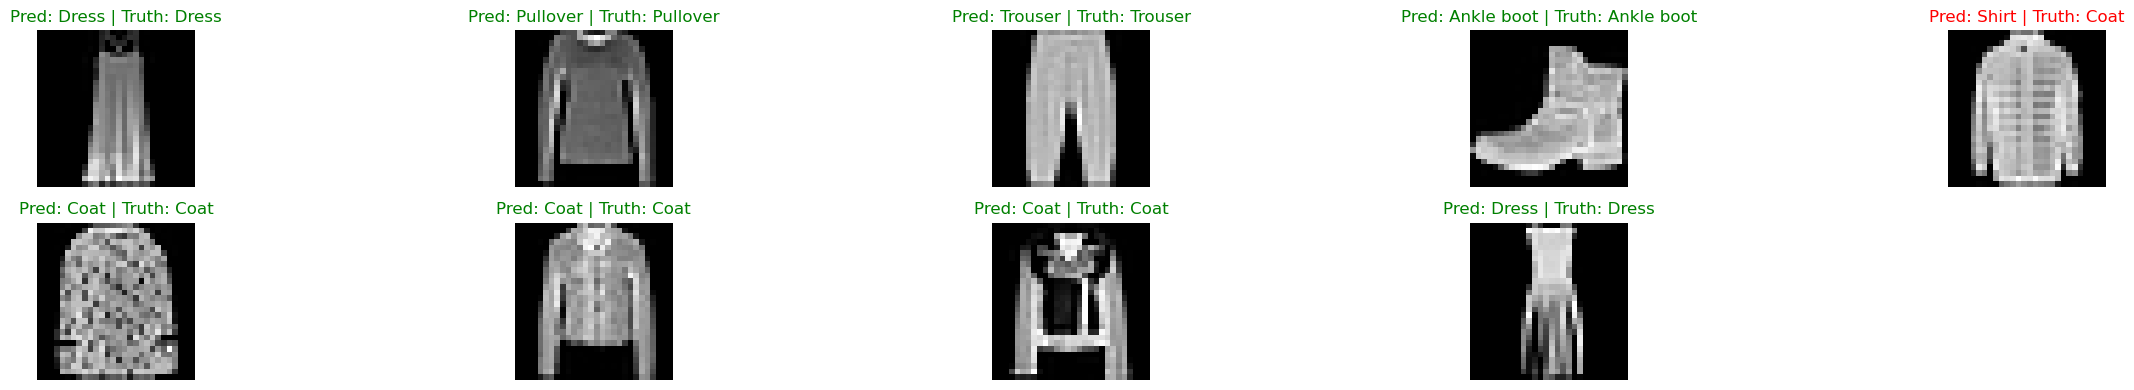

In [339]:
plt.figure(figsize=(25,4))
nrows = 2
ncols = 5
for i, sample in enumerate(test_sample):

    plt.subplot(nrows, ncols, i+1)

    plt.imshow(sample.squeeze(), cmap="gray")

    # prediction label
    pred_label = train_data.classes[pred_class[i]]

    # true label
    true_lb = train_data.classes[test_lb[i]]

    title_txt = f"Pred: {pred_label} | Truth: {true_lb}"

    if pred_label == true_lb:
        plt.title(title_txt, c="g") # correct prediction
    else:
        plt.title(title_txt, c="r") # wrong prediction

    plt.axis(False)
    
plt.tight_layout()
plt.show()

# 10. Confusion matrix for prediction evaluation
Very useful for finding in which class our model is performing bad. Therefore, we can find if there is error in our data or if our model needs to be imroved if no error in data is found.

In [438]:
def prediction(model: torch.nn.Module,
               data : list,
               device : torch.device = device):

    pred = []
    model.to(device)

    model.eval()
    with torch.inference_mode():
        for sample, _ in data:

            sample = sample.to(device)

            pred_logit = model(sample)

            pred_pr = torch.softmax(pred_logit.squeeze(), dim=0) # normally wont be required as done in accuracy function as argmax of logit will also yield the same results
            
            pred.append(pred_pr.argmax(dim=1).cpu()) # for plotting we need to convert to cpu

            # print(pred_pr.shape)

    return torch.cat(pred) # concatenate into single row

In [439]:
# prediction for test data
pred_class = prediction(model=model_cnn_0,
                       data=test_dataloader)
pred_class.shape

torch.Size([10000])

In [440]:
from torchmetrics import ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay

In [441]:
confmat = ConfusionMatrix(num_classes=len(train_data.classes), task="multiclass")

confmat_tens = confmat(preds=pred_class, target=test_data.targets).numpy()
confmat_tens

array([[697,   1,  47,  56,   6,   1, 184,   0,   8,   0],
       [ 13, 767,   3, 140,  61,   0,  14,   0,   2,   0],
       [  9,   2, 781,  16,  98,   0,  90,   0,   4,   0],
       [ 30,   7,  26, 863,  35,   0,  34,   0,   5,   0],
       [  3,   5, 134,  44, 682,   0, 127,   0,   5,   0],
       [  8,   3,   0,   5,   2, 828,   5,  48,  79,  22],
       [100,   5, 122,  57,  79,   0, 625,   0,  12,   0],
       [  3,   1,   0,   0,   0,  38,   0, 867,  19,  72],
       [ 17,   3,  11,  11,   5,  10,  23,   5, 914,   1],
       [  0,   1,   0,   4,   1,  22,   2,  65,  13, 892]])

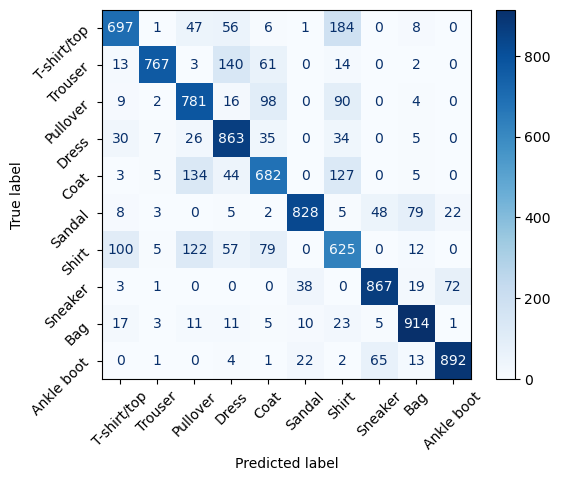

In [442]:
disp = ConfusionMatrixDisplay(confusion_matrix=confmat_tens, display_labels=train_data.classes) # create instance of confusion matrix
disp.plot(cmap=plt.cm.Blues) # plot

plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=45)  # Rotate y-axis labels
plt.show()

# 11. Saving and reloading the model

In [423]:
from pathlib import Path

In [427]:
# saving model

model_path = Path("model") # folder

model_path.mkdir(parents=True,
                 exist_ok=True) # model path create if not exist 

model_name = "03_pytoch_CV_mdoel.pth"
model_save_path = model_path / model_name # file path

print("Saving model ...")
torch.save(obj=model_cnn_0.state_dict(), f=model_save_path)
print("Modelled Saved!")

Saving model ...
Modelled Saved!


In [430]:
# loading model

torch.manual_seed(42)

# instantiate model
loaded_model_cnn = FashionMNISTCNN(inp_features=1,
                                   hidden_units=10,
                                   out_shape=len(train_data.classes), image_shape=28)

# load the trained model parameters
loaded_model_cnn.load_state_dict(torch.load(f=model_save_path, weights_only=False))

<All keys matched successfully>

Evaluate loaded model

In [436]:
# prediction for test data
pred_class = prediction(model=loaded_model_cnn,
                       data=test_dataloader)

confmat = ConfusionMatrix(num_classes=len(train_data.classes), task="multiclass")

confmat_tens = confmat(preds=pred_class, target=test_data.targets).numpy()

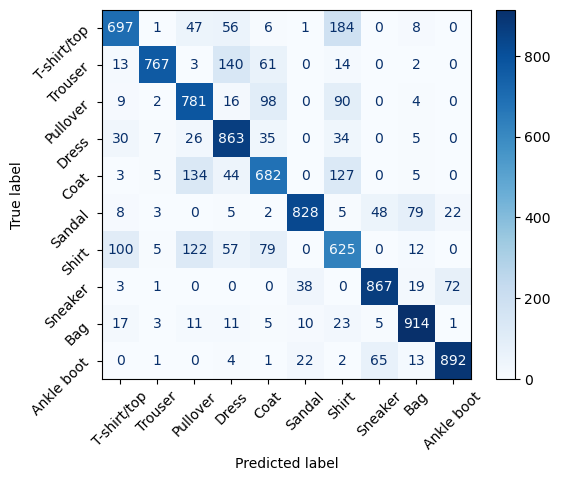

In [437]:
disp = ConfusionMatrixDisplay(confusion_matrix=confmat_tens, display_labels=train_data.classes) # create instance of confusion matrix
disp.plot(cmap=plt.cm.Blues) # plot

plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=45)  # Rotate y-axis labels
plt.show()

We can see that the loaded model produces the same results. We can also check using metrics like accuracy and computing the loss and comparing both the models.